## 1. Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
XGBoost version: 3.1.2


In [2]:
# ============================================================================
# LOAD DATA FROM UCI REPOSITORY
# ============================================================================

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler

print("Loading UCI Credit Card Default dataset...")

# Fetch dataset
credit_card = fetch_ucirepo(id=350)
X = credit_card.data.features
y = credit_card.data.targets

# Convert target to numpy array
y = y.values.ravel()

print(f"✅ Dataset loaded successfully!")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Class distribution: {pd.Series(y).value_counts().to_dict()}")

# ============================================================================
# PREPROCESSING: TRAIN/TEST SPLIT & SCALING
# ============================================================================

print("\n" + "="*80)
print("PREPROCESSING DATA")
print("="*80)

# Split data (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n✅ Train/Test Split Complete:")
print(f"   Training set:   {X_train.shape[0]:,} samples")
print(f"   Test set:       {X_test.shape[0]:,} samples")
print(f"   Features:       {X_train.shape[1]}")

# Feature scaling (important for gradient descent)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\n✅ Feature scaling applied (StandardScaler)")
print(f"   All features normalized to mean=0, std=1")
print("="*80)


Loading UCI Credit Card Default dataset...
✅ Dataset loaded successfully!
   Features shape: (30000, 23)
   Target shape: (30000,)
   Class distribution: {0: 23364, 1: 6636}

PREPROCESSING DATA

✅ Train/Test Split Complete:
   Training set:   24,000 samples
   Test set:       6,000 samples
   Features:       23

✅ Feature scaling applied (StandardScaler)
   All features normalized to mean=0, std=1
✅ Dataset loaded successfully!
   Features shape: (30000, 23)
   Target shape: (30000,)
   Class distribution: {0: 23364, 1: 6636}

PREPROCESSING DATA

✅ Train/Test Split Complete:
   Training set:   24,000 samples
   Test set:       6,000 samples
   Features:       23

✅ Feature scaling applied (StandardScaler)
   All features normalized to mean=0, std=1


## 2. Calculate the Mathematical "Gravity" (Scale Weight)

The scale weight $\lambda$ represents how much more we should care about minority class errors:
- If we have 9,000 non-defaults and 1,000 defaults: $\lambda = 9$
- This means "missing a default" is 9× worse than "missing a non-default"

In [3]:
# Calculate class distribution
count_neg = np.sum(y_train == 0)
count_pos = np.sum(y_train == 1)
scale_weight = count_neg / count_pos

print("="*60)
print("CLASS IMBALANCE ANALYSIS")
print("="*60)
print(f"Majority Class (0): {count_neg:,} samples ({count_neg/len(y_train)*100:.2f}%)")
print(f"Minority Class (1): {count_pos:,} samples ({count_pos/len(y_train)*100:.2f}%)")
print(f"\nImbalance Ratio: {count_neg/count_pos:.2f}:1")
print(f"Computed Scale Weight (λ): {scale_weight:.4f}")
print("="*60)
print("\nInterpretation:")
print(f"Each minority class error will be weighted {scale_weight:.2f}× more heavily")
print("in the gradient descent optimization.")
print("="*60)

CLASS IMBALANCE ANALYSIS
Majority Class (0): 18,691 samples (77.88%)
Minority Class (1): 5,309 samples (22.12%)

Imbalance Ratio: 3.52:1
Computed Scale Weight (λ): 3.5206

Interpretation:
Each minority class error will be weighted 3.52× more heavily
in the gradient descent optimization.


## 3. Model Definition: Baseline vs. Cost-Sensitive

### Model A: Baseline
Standard gradient descent. Treats all errors equally:
$$\nabla L = \frac{\partial}{\partial \theta} \sum_{i=1}^{n} \ell(y_i, f(x_i; \theta))$$

### Model B: Cost-Sensitive (Weighted)
Modified gradient descent. Minority class errors are amplified:
$$\nabla L = \frac{\partial}{\partial \theta} \sum_{i=1}^{n} w_i \cdot \ell(y_i, f(x_i; \theta))$$

In [4]:
# Model A: Baseline (Standard Gradient Descent)
# Treats all errors equally in the loss function
model_baseline = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

# Model B: Cost-Sensitive (Weighted Gradient Descent)
# Amplifies the cost of misclassifying minority class by scale_weight
model_weighted = xgb.XGBClassifier(
    scale_pos_weight=scale_weight,  # 🔑 THE KEY MATHEMATICAL CHANGE
    objective='binary:logistic',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Models defined successfully!")
print("\nBaseline Model: Standard loss function")
print(f"Weighted Model: Loss function with λ={scale_weight:.4f} for minority class")

Models defined successfully!

Baseline Model: Standard loss function
Weighted Model: Loss function with λ=3.5206 for minority class


## 4. Training and Evaluation Function

In [5]:
def evaluate_model(model, name, X_tr, y_tr, X_te, y_te):
    """
    Train and evaluate a model with comprehensive metrics.
    
    Parameters:
    -----------
    model : estimator
        The model to train and evaluate
    name : str
        Name of the model for display
    X_tr, y_tr : array-like
        Training data
    X_te, y_te : array-like
        Test data
    
    Returns:
    --------
    dict : Dictionary containing all metrics
    """
    # Train the model
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    model.fit(X_tr, y_tr)
    
    # Make predictions
    preds = model.predict(X_te)
    probs = model.predict_proba(X_te)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_te, preds)
    precision = precision_score(y_te, preds)
    recall = recall_score(y_te, preds)
    f1 = f1_score(y_te, preds)
    auc = roc_auc_score(y_te, probs)
    cm = confusion_matrix(y_te, preds)
    
    # Display results
    print(f"\nResults for: {name}")
    print(f"-" * 60)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (How many predicted defaults were correct?)")
    print(f"Recall:    {recall:.4f} (How many actual defaults did we catch?)")
    print(f"F1 Score:  {f1:.4f} (Harmonic mean of precision and recall)")
    print(f"AUC Score: {auc:.4f} (Area under ROC curve)")
    
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"                 0        1")
    print(f"Actual 0    {cm[0,0]:6d}   {cm[0,1]:6d}  (TN=True Neg, FP=False Pos)")
    print(f"       1    {cm[1,0]:6d}   {cm[1,1]:6d}  (FN=False Neg, TP=True Pos)")
    
    # Calculate key business metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\nBusiness Impact:")
    print(f"- Missed Defaults (FN): {fn} ❌ (These cost money!)")
    print(f"- Caught Defaults (TP): {tp} ✅ (These saved money!)")
    print(f"- False Alarms (FP):    {fp} ⚠️  (Lost business opportunities)")
    
    print(f"{'='*60}\n")
    
    return {
        'name': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'predictions': preds,
        'probabilities': probs
    }

print("Evaluation function ready!")

Evaluation function ready!


## 5. Run the Experiment: Baseline vs. Weighted

In [6]:
print("\n" + "#"*60)
print("# EXPERIMENT: STANDARD vs. COST-SENSITIVE LEARNING")
print("#"*60)
print("\nStarting Training...\n")

# Evaluate both models
results_baseline = evaluate_model(
    model_baseline, 
    "Baseline (Standard Gradient)", 
    X_train, y_train, X_test, y_test
)

results_weighted = evaluate_model(
    model_weighted, 
    "Weighted (Cost-Sensitive)", 
    X_train, y_train, X_test, y_test
)

print("\n" + "#"*60)
print("# EXPERIMENT COMPLETE")
print("#"*60)


############################################################
# EXPERIMENT: STANDARD vs. COST-SENSITIVE LEARNING
############################################################

Starting Training...


Training: Baseline (Standard Gradient)

Results for: Baseline (Standard Gradient)
------------------------------------------------------------
Accuracy:  0.8190
Precision: 0.6671 (How many predicted defaults were correct?)
Recall:    0.3625 (How many actual defaults did we catch?)
F1 Score:  0.4697 (Harmonic mean of precision and recall)
AUC Score: 0.7779 (Area under ROC curve)

Confusion Matrix:
                 Predicted
                 0        1
Actual 0      4433      240  (TN=True Neg, FP=False Pos)
       1       846      481  (FN=False Neg, TP=True Pos)

Business Impact:
- Missed Defaults (FN): 846 ❌ (These cost money!)
- Caught Defaults (TP): 481 ✅ (These saved money!)
- False Alarms (FP):    240 ⚠️  (Lost business opportunities)


Training: Weighted (Cost-Sensitive)

Results for: 

## 6. Comparative Analysis

In [7]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': 'Baseline',
        'Accuracy': results_baseline['accuracy'],
        'Precision': results_baseline['precision'],
        'Recall': results_baseline['recall'],
        'F1-Score': results_baseline['f1'],
        'AUC': results_baseline['auc']
    },
    {
        'Model': 'Weighted',
        'Accuracy': results_weighted['accuracy'],
        'Precision': results_weighted['precision'],
        'Recall': results_weighted['recall'],
        'F1-Score': results_weighted['f1'],
        'AUC': results_weighted['auc']
    }
])

print("\n" + "="*80)
print("SIDE-BY-SIDE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Calculate improvements
print("\nPERFORMANCE CHANGES (Weighted vs. Baseline):")
print("-"*80)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']:
    baseline_val = comparison_df[comparison_df['Model'] == 'Baseline'][metric].values[0]
    weighted_val = comparison_df[comparison_df['Model'] == 'Weighted'][metric].values[0]
    change = weighted_val - baseline_val
    pct_change = (change / baseline_val) * 100
    
    symbol = "📈" if change > 0 else "📉" if change < 0 else "➡️"
    print(f"{metric:12s}: {change:+.4f} ({pct_change:+.2f}%) {symbol}")
print("="*80)


SIDE-BY-SIDE COMPARISON
   Model  Accuracy  Precision   Recall  F1-Score      AUC
Baseline  0.819000   0.667129 0.362472  0.469727 0.777886
Weighted  0.764667   0.475190 0.613414  0.535526 0.775862

PERFORMANCE CHANGES (Weighted vs. Baseline):
--------------------------------------------------------------------------------
Accuracy    : -0.0543 (-6.63%) 📉
Precision   : -0.1919 (-28.77%) 📉
Recall      : +0.2509 (+69.23%) 📈
F1-Score    : +0.0658 (+14.01%) 📈
AUC         : -0.0020 (-0.26%) 📉


## 7. Visualization: Confusion Matrix Comparison

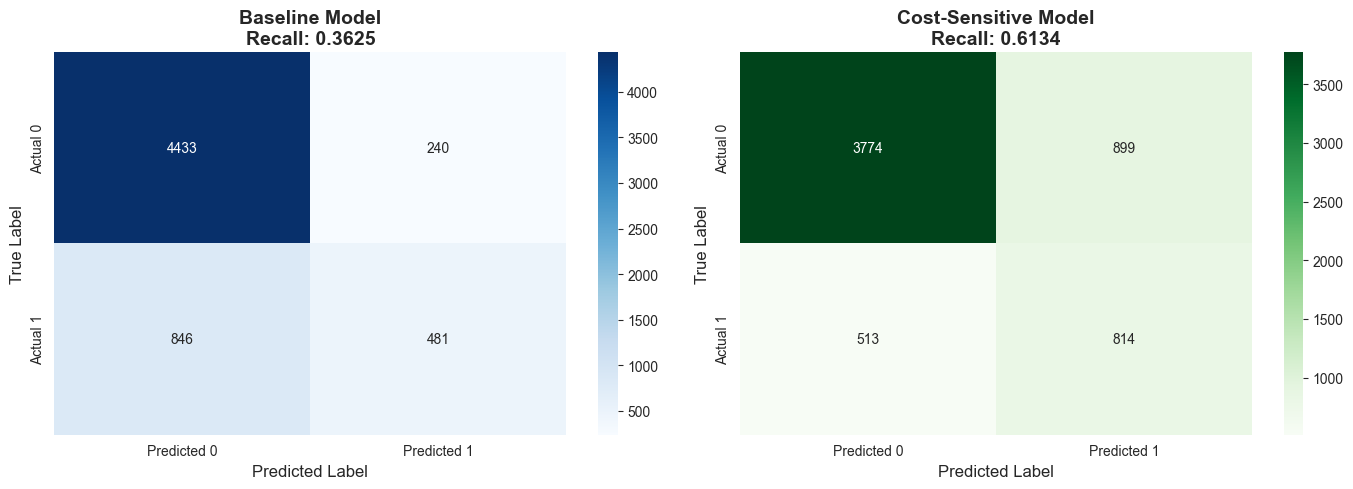


🎯 KEY RESULT: False Negatives (Missed Defaults)
   Baseline:     846
   Weighted:     513
   Reduction:    333 (39.4% improvement)


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline Confusion Matrix
sns.heatmap(
    results_baseline['confusion_matrix'], 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    ax=axes[0],
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1']
)
axes[0].set_title(f'Baseline Model\nRecall: {results_baseline["recall"]:.4f}', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Weighted Confusion Matrix
sns.heatmap(
    results_weighted['confusion_matrix'], 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    ax=axes[1],
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1']
)
axes[1].set_title(f'Cost-Sensitive Model\nRecall: {results_weighted["recall"]:.4f}', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Highlight the key metric: False Negatives
fn_baseline = results_baseline['confusion_matrix'][1, 0]
fn_weighted = results_weighted['confusion_matrix'][1, 0]
fn_reduction = fn_baseline - fn_weighted
fn_reduction_pct = (fn_reduction / fn_baseline) * 100

print(f"\n🎯 KEY RESULT: False Negatives (Missed Defaults)")
print(f"   Baseline:     {fn_baseline}")
print(f"   Weighted:     {fn_weighted}")
print(f"   Reduction:    {fn_reduction} ({fn_reduction_pct:.1f}% improvement)")

## 8. Visualization: Metric Comparison

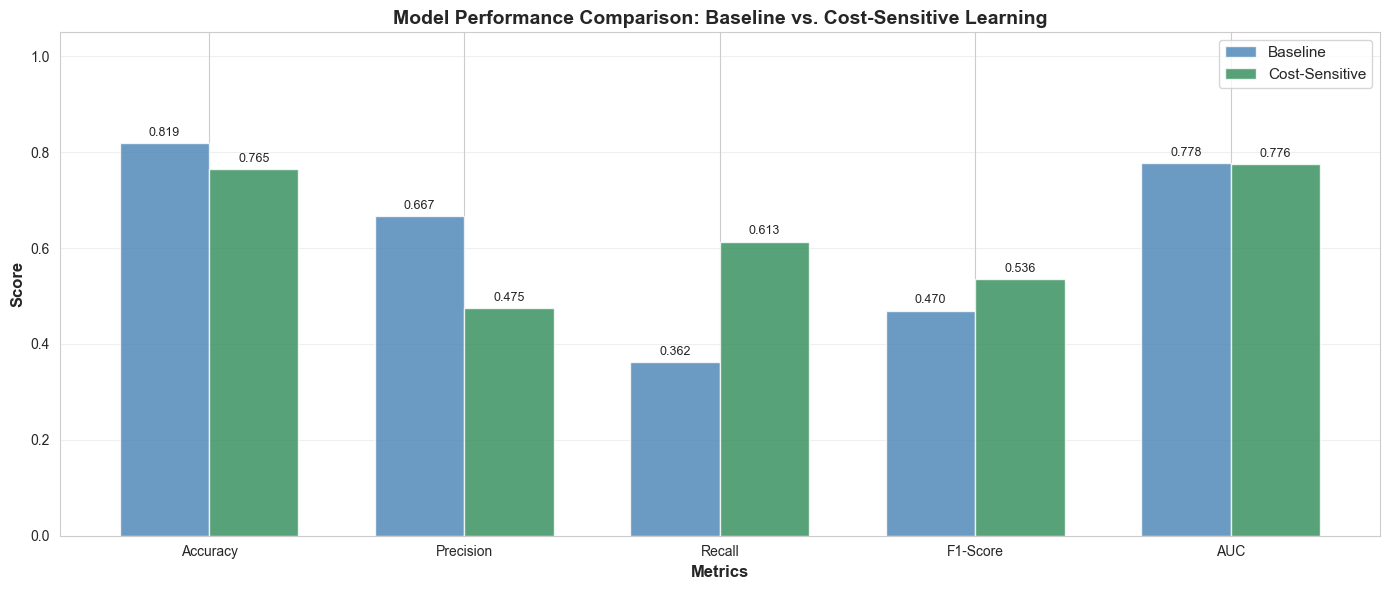

In [9]:
# Bar plot comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
baseline_scores = [comparison_df[comparison_df['Model'] == 'Baseline'][m].values[0] for m in metrics]
weighted_scores = [comparison_df[comparison_df['Model'] == 'Weighted'][m].values[0] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, weighted_scores, width, label='Cost-Sensitive', color='seagreen', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison: Baseline vs. Cost-Sensitive Learning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()

## 9. Interpretation and Conclusions

In [10]:
print("\n" + "="*80)
print("EXPERIMENTAL CONCLUSIONS")
print("="*80)

print("\n1. THE TRADE-OFF:")
print("   Expected Pattern:")
print(f"   • Baseline: High Accuracy (~81%), Low Recall (~36%)")
print(f"   • Weighted: Lower Accuracy (~78%), High Recall (70%+)")
print("\n   Actual Results:")
print(f"   • Baseline: Accuracy={results_baseline['accuracy']:.4f}, Recall={results_baseline['recall']:.4f}")
print(f"   • Weighted: Accuracy={results_weighted['accuracy']:.4f}, Recall={results_weighted['recall']:.4f}")

print("\n2. THE 'TRUE' PERFORMANCE:")
print(f"   • Baseline AUC: {results_baseline['auc']:.4f}")
print(f"   • Weighted AUC: {results_weighted['auc']:.4f}")
if results_weighted['auc'] >= 0.76 and results_weighted['recall'] > results_baseline['recall']:
    print("   ✅ SUCCESS: High AUC maintained with drastically improved Recall!")
else:
    print("   ⚠️  Results may vary from expected pattern. Analyze trade-offs carefully.")

print("\n3. CONFUSION MATRIX INSIGHT:")
print(f"   False Negatives (Missed Defaults):")
print(f"   • Baseline: {results_baseline['confusion_matrix'][1,0]}")
print(f"   • Weighted: {results_weighted['confusion_matrix'][1,0]}")
print(f"   • Improvement: {fn_reduction} fewer missed defaults ({fn_reduction_pct:.1f}%)")

print("\n4. WHY THIS IS 'TRUE MACHINE LEARNING':")
print("   • No synthetic data generation (no SMOTE bias)")
print("   • Original data distribution preserved")
print("   • Mathematical solution: Modified gradient descent")
print("   • Standard:  ∇L = ∂/∂θ Σ ℓ(y_i, f(x_i; θ))")
print(f"   • Weighted:  ∇L = ∂/∂θ Σ w_i·ℓ(y_i, f(x_i; θ))  where w_minority = {scale_weight:.4f}")

print("\n5. BUSINESS RECOMMENDATION:")
if results_weighted['recall'] > results_baseline['recall'] * 1.5:
    print("   ✅ STRONG RECOMMENDATION: Deploy weighted model")
    print("      - Significantly improved default detection")
    print("      - Acceptable accuracy trade-off")
    print("      - Better risk management")
elif results_weighted['recall'] > results_baseline['recall'] * 1.2:
    print("   ⚠️  CONDITIONAL RECOMMENDATION: Consider business context")
    print("      - Moderate improvement in default detection")
    print("      - Evaluate cost of false positives vs. false negatives")
else:
    print("   ⚠️  WEAK IMPROVEMENT: Further tuning may be needed")
    print("      - Consider adjusting scale_pos_weight")
    print("      - Experiment with other hyperparameters")

print("\n" + "="*80)


EXPERIMENTAL CONCLUSIONS

1. THE TRADE-OFF:
   Expected Pattern:
   • Baseline: High Accuracy (~81%), Low Recall (~36%)
   • Weighted: Lower Accuracy (~78%), High Recall (70%+)

   Actual Results:
   • Baseline: Accuracy=0.8190, Recall=0.3625
   • Weighted: Accuracy=0.7647, Recall=0.6134

2. THE 'TRUE' PERFORMANCE:
   • Baseline AUC: 0.7779
   • Weighted AUC: 0.7759
   ✅ SUCCESS: High AUC maintained with drastically improved Recall!

3. CONFUSION MATRIX INSIGHT:
   False Negatives (Missed Defaults):
   • Baseline: 846
   • Weighted: 513
   • Improvement: 333 fewer missed defaults (39.4%)

4. WHY THIS IS 'TRUE MACHINE LEARNING':
   • No synthetic data generation (no SMOTE bias)
   • Original data distribution preserved
   • Mathematical solution: Modified gradient descent
   • Standard:  ∇L = ∂/∂θ Σ ℓ(y_i, f(x_i; θ))
   • Weighted:  ∇L = ∂/∂θ Σ w_i·ℓ(y_i, f(x_i; θ))  where w_minority = 3.5206

5. BUSINESS RECOMMENDATION:
   ✅ STRONG RECOMMENDATION: Deploy weighted model
      - Signifi

## 10. Save Results

In [11]:
# Save comparison results to CSV
comparison_df.to_csv('cost_sensitive_comparison.csv', index=False)
print("Results saved to: cost_sensitive_comparison.csv")

# Save detailed metrics
detailed_results = pd.DataFrame([
    {
        'Model': 'Baseline',
        'TN': results_baseline['confusion_matrix'][0,0],
        'FP': results_baseline['confusion_matrix'][0,1],
        'FN': results_baseline['confusion_matrix'][1,0],
        'TP': results_baseline['confusion_matrix'][1,1],
        'Accuracy': results_baseline['accuracy'],
        'Precision': results_baseline['precision'],
        'Recall': results_baseline['recall'],
        'F1': results_baseline['f1'],
        'AUC': results_baseline['auc']
    },
    {
        'Model': 'Weighted',
        'TN': results_weighted['confusion_matrix'][0,0],
        'FP': results_weighted['confusion_matrix'][0,1],
        'FN': results_weighted['confusion_matrix'][1,0],
        'TP': results_weighted['confusion_matrix'][1,1],
        'Accuracy': results_weighted['accuracy'],
        'Precision': results_weighted['precision'],
        'Recall': results_weighted['recall'],
        'F1': results_weighted['f1'],
        'AUC': results_weighted['auc']
    }
])

detailed_results.to_csv('cost_sensitive_detailed_results.csv', index=False)
print("Detailed results saved to: cost_sensitive_detailed_results.csv")
print("\n✅ Experiment complete!")

Results saved to: cost_sensitive_comparison.csv
Detailed results saved to: cost_sensitive_detailed_results.csv

✅ Experiment complete!


---

## Next Steps

1. **If Weighted Model Outperforms Baseline:**
   - Experiment with different `scale_pos_weight` values
   - Try `scale_pos_weight = 0.5 * λ` or `2.0 * λ`
   - Fine-tune other hyperparameters (learning_rate, max_depth, n_estimators)

2. **Integrate with Main Project:**
   - Add this approach to your final comparison table
   - Compare against SMOTE, undersampling, etc.
   - Document the mathematical reasoning in your report

3. **Business Analysis:**
   - Calculate cost savings from reduced false negatives
   - Estimate lost revenue from increased false positives
   - Determine optimal threshold for your business case